In [1]:
# ===============================================================
#  HOMOCHIRALITY STEERING EXPERIMENT (CLEAN REWRITE)
#  Uses: QuTiP + CVXPY + SciPy logm
#  Author: Turbasu Chatterjee
# ===============================================================

import numpy as np
import qutip as qt
import cvxpy as cp
from scipy.linalg import logm, expm
import matplotlib.pyplot as plt
from tqdm import tqdm 
from scipy.optimize import nnls

In [2]:
# ===============================================================
# Hamiltonian + utilities
# ===============================================================
def generate_hamiltonians(a_values, b_values):
    sz, sx = qt.sigmaz(), qt.sigmax()
    return {(a, b): 0.5 * a * sz + 0.5 * b * sx for a in a_values for b in b_values}

def time_evolve_state(H, psi0, tlist):
    return qt.sesolve(H, psi0, tlist).states

In [3]:
# ===============================================================
# Choi helpers
# ===============================================================

def _J_block(J, i, j):
    r = slice(2 * i, 2 * (i + 1))
    c = slice(2 * j, 2 * (j + 1))
    return J[r, c]

def _phi_of_rho_from_choi(J, rho):
    """Φ(ρ) = Σ_{i,j} ρ_{j,i} * J_{i,j} (qubit)."""
    out = 0
    for i in range(2):
        for j in range(2):
            out += rho[j, i] * _J_block(J, i, j)
    return out

def _tp_constraints(J):
    """Trace preservation Tr_Y J = I_X for qubits, plus CP (J ⪰ 0)."""
    cons = [J >> 0]
    for i in range(2):
        for j in range(2):
            cons.append(cp.trace(_J_block(J, i, j)) == (1.0 if i == j else 0.0))
    return cons

def _covariance_constraints(J, H):
    """[H ⊗ I - I ⊗ Hᵗ, J] = 0 (linear)."""
    I2 = np.eye(2)
    Hm = H if isinstance(H, np.ndarray) else H.full()
    G = np.kron(Hm, I2) - np.kron(I2, Hm.T)
    return [G @ J - J @ G == 0]

def kraus_from_choi(J_opt):
    """Choi → Kraus (qubit)."""
    J_q = qt.Qobj(J_opt, dims=[[2, 2], [2, 2]])
    evals, evecs = J_q.eigenstates()
    K_list = []
    for lam, vec in zip(evals, evecs):
        if np.real(lam) > 1e-10:
            K = np.sqrt(lam) * vec.full().reshape(2, 2, order="F")
            K_list.append(qt.Qobj(K))
    return K_list

In [4]:
# ===============================================================
# Local steering SDP (per step)
# ===============================================================

def fidelity_sdp_step(
    rho_qobj,
    sigma_qobj,
    H_qobj,
    *,
    impose_covariance=True,
    impose_passivity=False,
    step_size=0.1,
    eta=1.0,
    p_min=None,
    verbose=False,
):
    """
    Local endpoint-only steering:
      maximize sqrtF(Φ(ρ), σ)
      s.t. J CPTP, optional covariance/passivity,
           step locality ||Φ(ρ)-ρ||_F ≤ eta*step_size,
           optional population floor Tr[|e><e| Φ(ρ)] ≥ p_min.
    """
    rho = rho_qobj.full()
    sigma = sigma_qobj.full()
    H = H_qobj.full()

    J = cp.Variable((4, 4), complex=True)
    W = cp.Variable((2, 2), complex=True)
    t = cp.Variable()

    constraints = _tp_constraints(J)
    if impose_covariance:
        constraints += _covariance_constraints(J, H)

    Phi_rho = _phi_of_rho_from_choi(J, rho)
    constraints += [Phi_rho >> 0, cp.trace(Phi_rho) == 1]

    # Locality proxy (keeps logm well-behaved)
    constraints += [cp.norm(Phi_rho - rho, "fro") <= eta * step_size]

    # Optional passivity
    if impose_passivity:
        lhs = cp.real(cp.trace(H @ Phi_rho))
        rhs = float(np.trace(H @ rho))
        constraints += [lhs <= rhs + 1e-12]

    # Optional per-step excited-population floor
    if p_min is not None:
        Pe = np.array([[0, 0], [0, 1]], dtype=complex)
        constraints += [cp.real(cp.trace(cp.kron(Pe, rho.T) @ J)) >= p_min]

    # Uhlmann fidelity block
    block = cp.bmat([[Phi_rho, W], [W.H, sigma]])
    constraints += [block >> 0, cp.real(cp.trace(W)) >= t]

    prob = cp.Problem(cp.Maximize(t), constraints)
    prob.solve(
        solver=cp.SCS,
        verbose=verbose,
        eps_abs=1e-4,
        eps_rel=1e-4,
        max_iters=30000,
    )

    sqrtF = float(prob.value) if prob.value is not None else np.nan
    F = sqrtF**2 if np.isfinite(sqrtF) else np.nan

    return dict(
        status=prob.status,
        sqrtF=sqrtF,
        fidelity=F,
        J=None if J.value is None else J.value.copy(),
        Phi_rho=None if Phi_rho.value is None else Phi_rho.value.copy(),
    )


In [5]:
# ===============================================================
# Kraus & GKSL extraction (from known H)
# ===============================================================

def gksl_from_kraus_and_H(kraus_ops, H, dt=1.0, eps=1e-10):
    """
    Given Kraus ops and known Hamiltonian H:
      L_total = (log Φ)/dt
      L_H     = -i(H ⊗ I - I ⊗ Hᵗ)
      L_D     = L_total - L_H
    """
    d = H.shape[0] if isinstance(H, np.ndarray) else H.shape[0]
    Phi = np.zeros((d * d, d * d), dtype=complex)
    for K in kraus_ops:
        Kmat = K.full() if isinstance(K, qt.Qobj) else K
        Phi += np.kron(Kmat, Kmat.conj())

    Phi_reg = (1 - eps) * Phi + eps * np.eye(d * d)
    L_total = (1.0 / dt) * logm(Phi_reg)

    Hm = H.full() if isinstance(H, qt.Qobj) else H
    I = np.eye(d)
    L_H = -1j * (np.kron(Hm, I) - np.kron(I, Hm.T))
    L_D = L_total - L_H
    return L_total, L_H, L_D

# Dissipator decomposition (σ-, σ+, σz dephasing)
def _diss_basis_qubit():
    sz, sp, sm = qt.sigmaz(), qt.sigmap(), qt.sigmam()
    Bd = qt.liouvillian(0 * sz, [sm]).full()
    Bu = qt.liouvillian(0 * sz, [sp]).full()
    Bp = qt.liouvillian(0 * sz, [sz]).full()
    return Bd, Bu, Bp

def decompose_dissipator_nnls_energy(L_D, H):
    Bd, Bu, Bp = diss_basis_in_energy(H)
    A = np.column_stack([Bd.reshape(-1,1), Bu.reshape(-1,1), Bp.reshape(-1,1)]).real
    b = np.real(L_D.reshape(-1,1))
    x, _ = nnls(A, b.ravel())
    g_down, g_up, g_phi = x
    p_e_inf = g_up/(g_up+g_down) if (g_up+g_down)>1e-15 else 0.0
    return dict(gamma_down=g_down, gamma_up=g_up, gamma_phi=g_phi, p_e_inf=p_e_inf)

def build_pure_pumping_generator_energy(L_H, L_D, H, force_pure_pumping=True):
    if not force_pure_pumping:
        return qt.Qobj(L_H + L_D, dims=[[2,2],[2,2]])
    Bd, Bu, Bp = diss_basis_in_energy(H)
    A = np.column_stack([Bd.reshape(-1,1), Bu.reshape(-1,1), Bp.reshape(-1,1)]).real
    b = np.real(L_D.reshape(-1,1))
    x, _ = nnls(A, b.ravel())
    g_down, g_up, g_phi = x
    g_down = 0.0  # enforce pure pumping toward |excited⟩
    L_D_pure = g_up*Bu + g_phi*Bp
    return qt.Qobj(L_H + L_D_pure, dims=[[2,2],[2,2]])

def _unitary_to_energy_basis(H):
    # columns are eigenvectors; evecs[0]=|g>, evecs[1]=|e>
    evals, evecs = H.eigenstates(sort='low')
    U = qt.Qobj(np.column_stack([evecs[0].full(), evecs[1].full()]))
    return U

def _rotate_op_to_lab(U, O_energy):
    # O_lab = U O_energy U^\dagger
    return U * O_energy * U.dag()

def diss_basis_in_energy(H):
    """Build Bd, Bu, Bp in the ENERGY basis of H, then rotate to lab frame and return Liouvillian matrices."""
    U = _unitary_to_energy_basis(H)
    # energy-basis jump ops (|g><e|, |e><g|, σz_energy)
    g = qt.basis(2,0)
    e = qt.basis(2,1)
    sm_E = g*e.dag()                 # |g><e|
    sp_E = e*g.dag()                 # |e><g|
    sz_E = qt.sigmaz()               # diag(+1,-1) in {g,e} order

    # rotate to lab (computational) frame
    sm = _rotate_op_to_lab(U, sm_E)
    sp = _rotate_op_to_lab(U, sp_E)
    sz = _rotate_op_to_lab(U, sz_E)

    # Liouvillian basis in lab frame
    Bd = qt.liouvillian(0*sz, [sm]).full()   # decay (e→g)
    Bu = qt.liouvillian(0*sz, [sp]).full()   # pumping (g→e)
    Bp = qt.liouvillian(0*sz, [sz]).full()   # dephasing in energy basis
    return Bd, Bu, Bp



In [6]:
# ===============================================================
# Diagnostics
# ===============================================================

def choi_from_super(Phi):
    """Choi(J) from superoperator Phi (qubit, F-order)."""
    J = np.zeros((4, 4), dtype=complex)
    for i in range(2):
        for j in range(2):
            eij = np.zeros((2, 2), complex)
            eij[i, j] = 1.0
            vec = eij.reshape(-1, 1, order="F")
            out = Phi @ vec
            Φ_eij = out.reshape(2, 2, order="F")
            r = slice(2 * i, 2 * (i + 1))
            c = slice(2 * j, 2 * (j + 1))
            J[r, c] = Φ_eij
    return J

def verify_L_strict(L_qobj, t=0.1, verbose=True):
    """TP (left/right), CP of e^{tL} via Choi ⪰ 0."""
    Lm = L_qobj.full()
    I2 = np.eye(2)
    vI = I2.reshape(-1, 1, order="F")
    tp_left = np.linalg.norm(vI.conj().T @ Lm)   # <I|L
    tp_right = np.linalg.norm(Lm @ vI)           # L|I>
    if verbose:
        print(f"TP left  = {tp_left:.3e}, TP right = {tp_right:.3e}")
    Phi_t = expm(Lm * t)
    J = choi_from_super(Phi_t)
    eigs = np.linalg.eigvalsh(0.5 * (J + J.conj().T))
    print(f"Min eigenvalue of Choi(e^(tL)): {np.min(eigs):.3e}")
    return tp_left, tp_right, eigs


In [7]:
def summarize_rates(L_D, H, label=""):
    """Prints dissipation rates, total Γ, relaxation time τ, and steady-state p_e(∞)."""
    rates = decompose_dissipator_nnls_energy(L_D, H)
    gamma_down = float(rates["gamma_down"])
    gamma_up   = float(rates["gamma_up"])
    gamma_phi  = float(rates["gamma_phi"])
    Gamma = gamma_down + gamma_up
    tau = 1.0 / Gamma if Gamma > 1e-15 else np.inf
    p_e_inf = rates["p_e_inf"]

    print(f"\n=== Rate summary ({label}) ===")
    print(f"γ↓ = {gamma_down:.5f},  γ↑ = {gamma_up:.5f},  γφ = {gamma_phi:.5f}")
    print(f"Γ  = {Gamma:.5f}   →  τ_pop = {tau:.5f}")
    print(f"Predicted steady population  p_e(∞) = {p_e_inf:.5f}")
    return rates, tau

Hamiltonians:   0%|          | 0/25 [00:00<?, ?H/s]/Users/tchatterjee/anaconda3/envs/pmp/lib/python3.13/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
Hamiltonians:   4%|▍         | 1/25 [00:21<08:24, 21.04s/H]

H=(np.float64(-2.0), np.float64(-1.0)): energy-basis rates={'gamma_down': np.float64(4.188988781950228), 'gamma_up': np.float64(0.8969735989314894), 'gamma_phi': np.float64(10.349955973176026), 'p_e_inf': np.float64(0.17636260981859395)}
Min eigenvalue of Choi(e^(tL)): -2.882e-17


Hamiltonians:   8%|▊         | 2/25 [00:41<07:58, 20.82s/H]

H=(np.float64(-2.0), np.float64(-0.5)): energy-basis rates={'gamma_down': np.float64(4.189052442813305), 'gamma_up': np.float64(0.8969619194162805), 'gamma_phi': np.float64(19.27182675403204), 'p_e_inf': np.float64(0.17635851091522953)}
Min eigenvalue of Choi(e^(tL)): -7.479e-17


Hamiltonians:  12%|█▏        | 3/25 [00:53<06:08, 16.73s/H]

H=(np.float64(-2.0), np.float64(0.0)): energy-basis rates={'gamma_down': np.float64(4.1890890598096), 'gamma_up': np.float64(0.8969602588186077), 'gamma_phi': np.float64(36.72114170474469), 'p_e_inf': np.float64(0.17635697230331476)}
Min eigenvalue of Choi(e^(tL)): 1.419e-17


Hamiltonians:  16%|█▌        | 4/25 [01:14<06:23, 18.27s/H]

H=(np.float64(-2.0), np.float64(0.5)): energy-basis rates={'gamma_down': np.float64(4.189054585087098), 'gamma_up': np.float64(0.8969629592185647), 'gamma_phi': np.float64(12.037317166906163), 'p_e_inf': np.float64(0.1763586050195226)}
Min eigenvalue of Choi(e^(tL)): -1.684e-17


Hamiltonians:  20%|██        | 5/25 [01:35<06:26, 19.34s/H]

H=(np.float64(-2.0), np.float64(1.0)): energy-basis rates={'gamma_down': np.float64(4.18901144142267), 'gamma_up': np.float64(0.8969845975316787), 'gamma_phi': np.float64(9.639468309267016), 'p_e_inf': np.float64(0.17636360521352146)}
Min eigenvalue of Choi(e^(tL)): 2.128e-17


Hamiltonians:  24%|██▍       | 6/25 [01:56<06:20, 20.01s/H]

H=(np.float64(-1.0), np.float64(-1.0)): energy-basis rates={'gamma_down': np.float64(4.188875028667025), 'gamma_up': np.float64(0.8969720673753182), 'gamma_phi': np.float64(11.529311710669168), 'p_e_inf': np.float64(0.17636630642579001)}
Min eigenvalue of Choi(e^(tL)): 1.362e-17


Hamiltonians:  28%|██▊       | 7/25 [02:18<06:09, 20.50s/H]

H=(np.float64(-1.0), np.float64(-0.5)): energy-basis rates={'gamma_down': np.float64(4.188964152507088), 'gamma_up': np.float64(0.8969659530720681), 'gamma_phi': np.float64(15.018493378499556), 'p_e_inf': np.float64(0.1763622256798448)}
Min eigenvalue of Choi(e^(tL)): 2.932e-16


Hamiltonians:  32%|███▏      | 8/25 [02:30<05:02, 17.80s/H]

H=(np.float64(-1.0), np.float64(0.0)): energy-basis rates={'gamma_down': np.float64(4.189037802296604), 'gamma_up': np.float64(0.8969625832790369), 'gamma_phi': np.float64(36.72115393800784), 'p_e_inf': np.float64(0.17635912608715174)}
Min eigenvalue of Choi(e^(tL)): 6.351e-18


Hamiltonians:  36%|███▌      | 9/25 [02:51<05:02, 18.90s/H]

H=(np.float64(-1.0), np.float64(0.5)): energy-basis rates={'gamma_down': np.float64(4.188964152507085), 'gamma_up': np.float64(0.8969659530720584), 'gamma_phi': np.float64(15.018493378499702), 'p_e_inf': np.float64(0.17636222567984336)}
Min eigenvalue of Choi(e^(tL)): 2.052e-16


Hamiltonians:  40%|████      | 10/25 [03:12<04:54, 19.64s/H]

H=(np.float64(-1.0), np.float64(1.0)): energy-basis rates={'gamma_down': np.float64(4.1888750286670255), 'gamma_up': np.float64(0.8969720673753206), 'gamma_phi': np.float64(11.5293117106691), 'p_e_inf': np.float64(0.1763663064257904)}
Min eigenvalue of Choi(e^(tL)): -6.009e-17


/var/folders/7d/xvfh5ghn7gd9q1vmfcky51h80000gn/T/ipykernel_12579/1867268162.py:19: RuntimeWarning: logm result may be inaccurate, approximate err = 6.921371056421193e-13
  L_total = (1.0 / dt) * logm(Phi_reg)
Hamiltonians:  44%|████▍     | 11/25 [03:32<04:36, 19.75s/H]

H=(np.float64(0.0), np.float64(-1.0)): energy-basis rates={'gamma_down': np.float64(6.918390887301362), 'gamma_up': np.float64(0.6900752577571215), 'gamma_phi': np.float64(9.219016658918205), 'p_e_inf': np.float64(0.09069834111114615)}
Min eigenvalue of Choi(e^(tL)): 1.062e-16


/var/folders/7d/xvfh5ghn7gd9q1vmfcky51h80000gn/T/ipykernel_12579/1867268162.py:19: RuntimeWarning: logm result may be inaccurate, approximate err = 3.9376710359381647e-13
  L_total = (1.0 / dt) * logm(Phi_reg)
Hamiltonians:  48%|████▊     | 12/25 [03:52<04:17, 19.81s/H]

H=(np.float64(0.0), np.float64(-0.5)): energy-basis rates={'gamma_down': np.float64(6.918273230610613), 'gamma_up': np.float64(0.6900738770422484), 'gamma_phi': np.float64(10.199277885646488), 'p_e_inf': np.float64(0.09069957867039703)}
Min eigenvalue of Choi(e^(tL)): 7.831e-16


Hamiltonians:  52%|█████▏    | 13/25 [04:04<03:29, 17.46s/H]

H=(np.float64(0.0), np.float64(0.0)): energy-basis rates={'gamma_down': np.float64(4.1890138431687065), 'gamma_up': np.float64(0.8969636697601376), 'gamma_phi': np.float64(36.72115965616953), 'p_e_inf': np.float64(0.17636013283189023)}
Min eigenvalue of Choi(e^(tL)): 0.000e+00


/var/folders/7d/xvfh5ghn7gd9q1vmfcky51h80000gn/T/ipykernel_12579/1867268162.py:19: RuntimeWarning: logm result may be inaccurate, approximate err = 3.334807921765664e-13
  L_total = (1.0 / dt) * logm(Phi_reg)
Hamiltonians:  56%|█████▌    | 14/25 [04:24<03:20, 18.25s/H]

H=(np.float64(0.0), np.float64(0.5)): energy-basis rates={'gamma_down': np.float64(6.918273230610611), 'gamma_up': np.float64(0.690073877042249), 'gamma_phi': np.float64(10.199277885646488), 'p_e_inf': np.float64(0.09069957867039713)}
Min eigenvalue of Choi(e^(tL)): 3.717e-16


/var/folders/7d/xvfh5ghn7gd9q1vmfcky51h80000gn/T/ipykernel_12579/1867268162.py:19: RuntimeWarning: logm result may be inaccurate, approximate err = 9.054032282799381e-13
  L_total = (1.0 / dt) * logm(Phi_reg)
Hamiltonians:  60%|██████    | 15/25 [04:44<03:07, 18.76s/H]

H=(np.float64(0.0), np.float64(1.0)): energy-basis rates={'gamma_down': np.float64(6.9183908873013635), 'gamma_up': np.float64(0.6900752577571219), 'gamma_phi': np.float64(9.219016658918207), 'p_e_inf': np.float64(0.09069834111114618)}
Min eigenvalue of Choi(e^(tL)): -1.210e-16


Hamiltonians:  64%|██████▍   | 16/25 [05:05<02:53, 19.31s/H]

H=(np.float64(1.0), np.float64(-1.0)): energy-basis rates={'gamma_down': np.float64(8.854469368942063), 'gamma_up': np.float64(0.5174432846770876), 'gamma_phi': np.float64(9.457989162313657), 'p_e_inf': np.float64(0.055212132656535864)}
Min eigenvalue of Choi(e^(tL)): -5.677e-16


Hamiltonians:  68%|██████▊   | 17/25 [05:25<02:37, 19.65s/H]

H=(np.float64(1.0), np.float64(-0.5)): energy-basis rates={'gamma_down': np.float64(9.22933427506073), 'gamma_up': np.float64(0.4859827782213816), 'gamma_phi': np.float64(11.045848217831738), 'p_e_inf': np.float64(0.05002232820154878)}
Min eigenvalue of Choi(e^(tL)): 3.008e-16


Hamiltonians:  72%|███████▏  | 18/25 [05:37<02:00, 17.23s/H]

H=(np.float64(1.0), np.float64(0.0)): energy-basis rates={'gamma_down': np.float64(2.3952137855812), 'gamma_up': np.float64(0.23888017808102754), 'gamma_phi': np.float64(37.33413054348619), 'p_e_inf': np.float64(0.09068779678189923)}
Min eigenvalue of Choi(e^(tL)): -5.551e-17


Hamiltonians:  76%|███████▌  | 19/25 [05:58<01:49, 18.20s/H]

H=(np.float64(1.0), np.float64(0.5)): energy-basis rates={'gamma_down': np.float64(9.229334275060726), 'gamma_up': np.float64(0.48598277822138275), 'gamma_phi': np.float64(11.045848217831768), 'p_e_inf': np.float64(0.05002232820154892)}
Min eigenvalue of Choi(e^(tL)): 8.980e-17


Hamiltonians:  80%|████████  | 20/25 [06:18<01:34, 18.91s/H]

H=(np.float64(1.0), np.float64(1.0)): energy-basis rates={'gamma_down': np.float64(8.854469368942079), 'gamma_up': np.float64(0.5174432846770858), 'gamma_phi': np.float64(9.457989162313737), 'p_e_inf': np.float64(0.055212132656535594)}
Min eigenvalue of Choi(e^(tL)): 8.814e-17


Hamiltonians:  84%|████████▍ | 21/25 [06:39<01:17, 19.37s/H]

H=(np.float64(2.0), np.float64(-1.0)): energy-basis rates={'gamma_down': np.float64(9.22978936810939), 'gamma_up': np.float64(0.48594286577119955), 'gamma_phi': np.float64(10.914882719127318), 'p_e_inf': np.float64(0.0500160825837321)}
Min eigenvalue of Choi(e^(tL)): -8.436e-17


Hamiltonians:  88%|████████▊ | 22/25 [06:59<00:58, 19.59s/H]

H=(np.float64(2.0), np.float64(-0.5)): energy-basis rates={'gamma_down': np.float64(9.370962327429567), 'gamma_up': np.float64(0.4743559142233549), 'gamma_phi': np.float64(14.886428942746884), 'p_e_inf': np.float64(0.04818086145925494)}
Min eigenvalue of Choi(e^(tL)): 2.513e-17


Hamiltonians:  92%|█████████▏| 23/25 [07:10<00:34, 17.24s/H]

H=(np.float64(2.0), np.float64(0.0)): energy-basis rates={'gamma_down': np.float64(2.3952100914741377), 'gamma_up': np.float64(0.23887215015835075), 'gamma_phi': np.float64(37.334133473993624), 'p_e_inf': np.float64(0.0906851526436427)}
Min eigenvalue of Choi(e^(tL)): -2.812e-39


Hamiltonians:  96%|█████████▌| 24/25 [07:31<00:18, 18.11s/H]

H=(np.float64(2.0), np.float64(0.5)): energy-basis rates={'gamma_down': np.float64(9.370962959040975), 'gamma_up': np.float64(0.474355969842074), 'gamma_phi': np.float64(13.217188069017242), 'p_e_inf': np.float64(0.04818086374535453)}
Min eigenvalue of Choi(e^(tL)): -1.979e-17


Hamiltonians: 100%|██████████| 25/25 [07:51<00:00, 18.86s/H]

H=(np.float64(2.0), np.float64(1.0)): energy-basis rates={'gamma_down': np.float64(9.229790347475518), 'gamma_up': np.float64(0.4859429558525677), 'gamma_phi': np.float64(10.849248768230686), 'p_e_inf': np.float64(0.05001608634997318)}
Min eigenvalue of Choi(e^(tL)): 2.706e-16

=== Rate summary (H=(np.float64(2.0), np.float64(1.0))) ===
γ↓ = 9.22979,  γ↑ = 0.48594,  γφ = 10.84925
Γ  = 9.71573   →  τ_pop = 0.10293
Predicted steady population  p_e(∞) = 0.05002


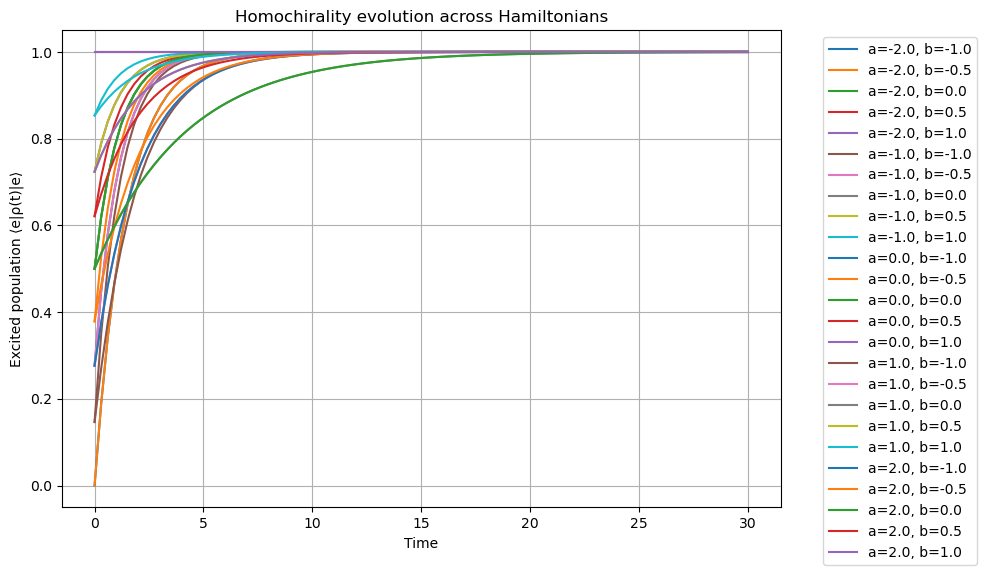


Steady-state populations:
H=(np.float64(-2.0), np.float64(-1.0)): final ⟨e|ρ(t_final)|e⟩ = 1.000, p_e_inf(pred)=0.176
H=(np.float64(-2.0), np.float64(-0.5)): final ⟨e|ρ(t_final)|e⟩ = 1.000, p_e_inf(pred)=0.176
H=(np.float64(-2.0), np.float64(0.0)): final ⟨e|ρ(t_final)|e⟩ = 1.000, p_e_inf(pred)=0.176
H=(np.float64(-2.0), np.float64(0.5)): final ⟨e|ρ(t_final)|e⟩ = 1.000, p_e_inf(pred)=0.176
H=(np.float64(-2.0), np.float64(1.0)): final ⟨e|ρ(t_final)|e⟩ = 1.000, p_e_inf(pred)=0.176
H=(np.float64(-1.0), np.float64(-1.0)): final ⟨e|ρ(t_final)|e⟩ = 1.000, p_e_inf(pred)=0.176
H=(np.float64(-1.0), np.float64(-0.5)): final ⟨e|ρ(t_final)|e⟩ = 1.000, p_e_inf(pred)=0.176
H=(np.float64(-1.0), np.float64(0.0)): final ⟨e|ρ(t_final)|e⟩ = 1.000, p_e_inf(pred)=0.176
H=(np.float64(-1.0), np.float64(0.5)): final ⟨e|ρ(t_final)|e⟩ = 1.000, p_e_inf(pred)=0.176
H=(np.float64(-1.0), np.float64(1.0)): final ⟨e|ρ(t_final)|e⟩ = 1.000, p_e_inf(pred)=0.176
H=(np.float64(0.0), np.float64(-1.0)): final ⟨e|ρ(t_final)|

In [8]:


# ----- Tunables -----
a_vals = np.linspace(-2, 2, 5)
b_vals = np.linspace(-1, 1, 5)

impose_covariance = True
impose_passivity = False
eta = 1.0            # SDP locality parameter
p_min = 0.95         # per-step excited-pop floor (None disables)
force_pure_pumping = True  # zero γ_down in energy basis

tlist = np.linspace(0, 30, 100)
dt = tlist[1] - tlist[0]

# initial superposition
psi_super = (qt.basis(2, 0) + qt.basis(2, 1)).unit()
rho_super0 = qt.ket2dm(psi_super)

# generate all Hamiltonians
hams = generate_hamiltonians(a_vals, b_vals)

# store results
results_all = {}

# ----- Main loop over Hamiltonians -----
for key, H in tqdm(hams.items(), desc="Hamiltonians", unit="H"):

    evals, evecs = H.eigenstates(sort="low")
    ground, excited = evecs[0], evecs[1]
    rho0 = qt.ket2dm(ground)
    sigma_target = qt.ket2dm(excited)

    # ----- Unitary pre-evolution -----
    states_t = time_evolve_state(H, ground, tlist)

    # ----- Solve steering SDPs -----
    sdp_results = []
    for psi_t in states_t:
        rho_t = qt.ket2dm(psi_t)
        out = fidelity_sdp_step(
            rho_t,
            sigma_target,
            H,
            impose_covariance=impose_covariance,
            impose_passivity=impose_passivity,
            step_size=dt,
            eta=eta,
            p_min=p_min,
            verbose=False,
        )
        sdp_results.append(out)

    # pick a representative channel (e.g., step 10)
    idx = 10 if len(sdp_results) > 10 else 0
    out = sdp_results[idx]

    if out["J"] is None:
        print(f"Skipping H={key}: SDP failed.")
        continue

    # ----- Extract generator -----
    kraus_ops = kraus_from_choi(out["J"])
    L_total, L_H, L_D = gksl_from_kraus_and_H(kraus_ops, H, dt=dt)

    # analyze rates
    rates = decompose_dissipator_nnls_energy(L_D, H)
    print(f"H={key}: energy-basis rates={rates}")

    # build generator (pure pumping)
    L_total_q = build_pure_pumping_generator_energy(L_H, L_D, H, force_pure_pumping)

    # optional diagnostic
    verify_L_strict(L_total_q, t=dt, verbose=False)

    # ----- Evolve under the fitted GKSL -----
    Pe_exc = sigma_target
    rho_list = []
    p_excited = []
    purity = []

    for t in tlist:
        Phi_t = expm(L_total_q.full() * t)
        rho_vec = qt.operator_to_vector(rho_super0).full()
        rho_t_vec = Phi_t @ rho_vec
        rho_t = qt.Qobj(rho_t_vec.reshape((2, 2), order="F"))
        rho_list.append(rho_t)
        p_excited.append(qt.expect(Pe_exc, rho_t))
        purity.append(np.real((rho_t * rho_t).tr()))

    results_all[key] = dict(
        H=H, rates=rates, p_excited=np.array(p_excited), purity=np.array(purity)
    )

rates, tau = summarize_rates(L_D, H, label=f"H={key}")

# ----- Comparative plots -----
plt.figure(figsize=(10, 6))
for key, res in results_all.items():
    a, b = key
    plt.plot(tlist, res["p_excited"], label=f"a={a:.1f}, b={b:.1f}")
plt.xlabel("Time")
plt.ylabel("Excited population ⟨e|ρ(t)|e⟩")
plt.title("Homochirality evolution across Hamiltonians")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.grid(True)
plt.show()

# ----- Optional: summarize steady-state populations -----
print("\nSteady-state populations:")
for key, res in results_all.items():
    print(f"H={key}: final ⟨e|ρ(t_final)|e⟩ = {res['p_excited'][-1]:.3f}, p_e_inf(pred)={res['rates']['p_e_inf']:.3f}")


In [9]:
# ----- Tunables -----
a_vals = np.linspace(-2, 2, 5)
b_vals = np.linspace(-1, 1, 5)

impose_covariance = True
impose_passivity = False
eta = 1.0
p_min = 0.95
force_pure_decay = True  # ← now we bias decay instead of pumping

tlist = np.linspace(0, 30, 100)
dt = tlist[1] - tlist[0]

# initial superposition
psi_super = (qt.basis(2, 0) + qt.basis(2, 1)).unit()
rho_super0 = qt.ket2dm(psi_super)

hams = generate_hamiltonians(a_vals, b_vals)
results_all = {}

for key, H in tqdm(hams.items(), desc="Hamiltonians", unit="H"):

    evals, evecs = H.eigenstates(sort="low")
    ground, excited = evecs[0], evecs[1]
    rho0 = qt.ket2dm(ground)
    sigma_target = qt.ket2dm(ground)   # ← targeting ground now!

    # pre-evolution
    states_t = time_evolve_state(H, ground, tlist)

    # local steering SDPs
    sdp_results = []
    for psi_t in states_t:
        rho_t = qt.ket2dm(psi_t)
        out = fidelity_sdp_step(
            rho_t,
            sigma_target,
            H,
            impose_covariance=impose_covariance,
            impose_passivity=impose_passivity,
            step_size=dt,
            eta=eta,
            p_min=p_min,
            verbose=False,
        )
        sdp_results.append(out)

    idx = 10 if len(sdp_results) > 10 else 0
    out = sdp_results[idx]
    if out["J"] is None:
        continue

    kraus_ops = kraus_from_choi(out["J"])
    L_total, L_H, L_D = gksl_from_kraus_and_H(kraus_ops, H, dt=dt)

    # estimate rates
    rates = decompose_dissipator_nnls_energy(L_D, H)
    print(f"H={key}: rates={rates}")

    # enforce *pure decay* (γ_up = 0)
    Bd, Bu, Bp = diss_basis_in_energy(H)
    A = np.column_stack([Bd.reshape(-1,1), Bu.reshape(-1,1), Bp.reshape(-1,1)]).real
    b = np.real(L_D.reshape(-1,1))
    x, _ = nnls(A, b.ravel())
    g_down, g_up, g_phi = x
    if force_pure_decay:
        g_up = 0.0
    L_D_pure = g_down * Bd + g_phi * Bp
    L_total_q = qt.Qobj(L_H + L_D_pure, dims=[[2,2],[2,2]])

    verify_L_strict(L_total_q, t=dt, verbose=False)

    # evolve & measure ⟨g|ρ(t)|g⟩
    Pe_ground = sigma_target
    p_ground = []
    purity = []
    for t in tlist:
        Phi_t = expm(L_total_q.full() * t)
        rho_vec = qt.operator_to_vector(rho_super0).full()
        rho_t = qt.Qobj((Phi_t @ rho_vec).reshape((2,2), order="F"))
        p_ground.append(qt.expect(Pe_ground, rho_t))
        purity.append(np.real((rho_t * rho_t).tr()))

    results_all[key] = dict(
        H=H, rates=rates, p_ground=np.array(p_ground), purity=np.array(purity)
    )
    
rates, tau = summarize_rates(L_D, H, label=f"H={key}")

print("\nSteady-state ground populations:")
for key, res in results_all.items():
    p_inf = 1 - res["rates"]["p_e_inf"]
    print(f"H={key}: final ⟨g|ρ|g⟩ = {res['p_ground'][-1]:.3f}, predicted={p_inf:.3f}")

Hamiltonians:   4%|▍         | 1/25 [00:01<00:37,  1.58s/H]

H=(np.float64(-2.0), np.float64(-1.0)): rates={'gamma_down': np.float64(13.562137611357688), 'gamma_up': np.float64(0.0), 'gamma_phi': np.float64(21.816038099470166), 'p_e_inf': np.float64(0.0)}
Min eigenvalue of Choi(e^(tL)): 6.075e-17


Hamiltonians:   8%|▊         | 2/25 [00:03<00:36,  1.60s/H]

H=(np.float64(-2.0), np.float64(-0.5)): rates={'gamma_down': np.float64(14.13572368915775), 'gamma_up': np.float64(0.0), 'gamma_phi': np.float64(22.846861797523328), 'p_e_inf': np.float64(0.0)}
Min eigenvalue of Choi(e^(tL)): 2.358e-17


Hamiltonians:  12%|█▏        | 3/25 [00:04<00:35,  1.63s/H]

H=(np.float64(-2.0), np.float64(0.0)): rates={'gamma_down': np.float64(14.111607506718915), 'gamma_up': np.float64(0.0), 'gamma_phi': np.float64(34.46475215772202), 'p_e_inf': np.float64(0.0)}
Min eigenvalue of Choi(e^(tL)): -1.165e-33


Hamiltonians:  16%|█▌        | 4/25 [00:06<00:34,  1.63s/H]

H=(np.float64(-2.0), np.float64(0.5)): rates={'gamma_down': np.float64(14.13572368915546), 'gamma_up': np.float64(0.0), 'gamma_phi': np.float64(22.848925875055055), 'p_e_inf': np.float64(0.0)}
Min eigenvalue of Choi(e^(tL)): -1.068e-16


Hamiltonians:  20%|██        | 5/25 [00:08<00:33,  1.65s/H]

H=(np.float64(-2.0), np.float64(1.0)): rates={'gamma_down': np.float64(13.562137611357793), 'gamma_up': np.float64(0.0), 'gamma_phi': np.float64(21.815102617553517), 'p_e_inf': np.float64(0.0)}
Min eigenvalue of Choi(e^(tL)): 7.021e-17


Hamiltonians:  24%|██▍       | 6/25 [00:09<00:31,  1.64s/H]

H=(np.float64(-1.0), np.float64(-1.0)): rates={'gamma_down': np.float64(13.722497160504272), 'gamma_up': np.float64(0.0), 'gamma_phi': np.float64(23.699389029373883), 'p_e_inf': np.float64(0.0)}
Min eigenvalue of Choi(e^(tL)): -2.495e-17


Hamiltonians:  28%|██▊       | 7/25 [00:11<00:29,  1.65s/H]

H=(np.float64(-1.0), np.float64(-0.5)): rates={'gamma_down': np.float64(13.298788100370647), 'gamma_up': np.float64(0.0), 'gamma_phi': np.float64(26.921588054966023), 'p_e_inf': np.float64(0.0)}
Min eigenvalue of Choi(e^(tL)): 3.986e-16


Hamiltonians:  32%|███▏      | 8/25 [00:13<00:27,  1.63s/H]

H=(np.float64(-1.0), np.float64(0.0)): rates={'gamma_down': np.float64(14.361146419982434), 'gamma_up': np.float64(0.0), 'gamma_phi': np.float64(34.40236742940614), 'p_e_inf': np.float64(0.0)}
Min eigenvalue of Choi(e^(tL)): -8.411e-34


Hamiltonians:  36%|███▌      | 9/25 [00:14<00:26,  1.63s/H]

H=(np.float64(-1.0), np.float64(0.5)): rates={'gamma_down': np.float64(13.298788100370656), 'gamma_up': np.float64(0.0), 'gamma_phi': np.float64(26.921588053224962), 'p_e_inf': np.float64(0.0)}
Min eigenvalue of Choi(e^(tL)): -1.218e-16


Hamiltonians:  40%|████      | 10/25 [00:16<00:24,  1.62s/H]

H=(np.float64(-1.0), np.float64(1.0)): rates={'gamma_down': np.float64(13.722497160504261), 'gamma_up': np.float64(0.0), 'gamma_phi': np.float64(23.69938902955908), 'p_e_inf': np.float64(0.0)}
Min eigenvalue of Choi(e^(tL)): 1.555e-16


Hamiltonians:  44%|████▍     | 11/25 [00:17<00:22,  1.61s/H]

H=(np.float64(0.0), np.float64(-1.0)): rates={'gamma_down': np.float64(13.98478774755479), 'gamma_up': np.float64(0.00014736845698837262), 'gamma_phi': np.float64(24.938584611988876), 'p_e_inf': np.float64(1.0537657541195596e-05)}
Min eigenvalue of Choi(e^(tL)): 1.296e-16


Hamiltonians:  48%|████▊     | 12/25 [00:19<00:20,  1.60s/H]

H=(np.float64(0.0), np.float64(-0.5)): rates={'gamma_down': np.float64(13.895793144140699), 'gamma_up': np.float64(0.00014928213071807578), 'gamma_phi': np.float64(21.5647441931062), 'p_e_inf': np.float64(1.0742857601068187e-05)}
Min eigenvalue of Choi(e^(tL)): 1.467e-16


Hamiltonians:  52%|█████▏    | 13/25 [00:21<00:19,  1.65s/H]

H=(np.float64(0.0), np.float64(0.0)): rates={'gamma_down': np.float64(13.985117022116896), 'gamma_up': np.float64(0.0), 'gamma_phi': np.float64(34.49637477887252), 'p_e_inf': np.float64(0.0)}
Min eigenvalue of Choi(e^(tL)): 0.000e+00


Hamiltonians:  56%|█████▌    | 14/25 [00:22<00:18,  1.65s/H]

H=(np.float64(0.0), np.float64(0.5)): rates={'gamma_down': np.float64(13.895793144140738), 'gamma_up': np.float64(0.00014928213072229463), 'gamma_phi': np.float64(21.564744193163104), 'p_e_inf': np.float64(1.0742857601371755e-05)}
Min eigenvalue of Choi(e^(tL)): 2.837e-16


Hamiltonians:  60%|██████    | 15/25 [00:24<00:16,  1.68s/H]

H=(np.float64(0.0), np.float64(1.0)): rates={'gamma_down': np.float64(13.984787747554794), 'gamma_up': np.float64(0.00014736845698837262), 'gamma_phi': np.float64(24.938584611988876), 'p_e_inf': np.float64(1.0537657541195593e-05)}
Min eigenvalue of Choi(e^(tL)): 2.875e-16


Hamiltonians:  64%|██████▍   | 16/25 [00:26<00:15,  1.68s/H]

H=(np.float64(1.0), np.float64(-1.0)): rates={'gamma_down': np.float64(18.677696940010406), 'gamma_up': np.float64(7.659444936675207e-05), 'gamma_phi': np.float64(20.385360851763014), 'p_e_inf': np.float64(4.100834032784382e-06)}
Min eigenvalue of Choi(e^(tL)): 2.601e-16


Hamiltonians:  68%|██████▊   | 17/25 [00:27<00:13,  1.67s/H]

H=(np.float64(1.0), np.float64(-0.5)): rates={'gamma_down': np.float64(22.739657765869396), 'gamma_up': np.float64(0.0), 'gamma_phi': np.float64(20.09462020922799), 'p_e_inf': np.float64(0.0)}
Min eigenvalue of Choi(e^(tL)): -1.299e-17


Hamiltonians:  72%|███████▏  | 18/25 [00:29<00:11,  1.69s/H]

H=(np.float64(1.0), np.float64(0.0)): rates={'gamma_down': np.float64(2.2873939586684746), 'gamma_up': np.float64(1.8670150273440873e-05), 'gamma_phi': np.float64(37.42080087719706), 'p_e_inf': np.float64(8.162126080016618e-06)}
Min eigenvalue of Choi(e^(tL)): -8.713e-17


Hamiltonians:  76%|███████▌  | 19/25 [00:31<00:10,  1.69s/H]

H=(np.float64(1.0), np.float64(0.5)): rates={'gamma_down': np.float64(22.739657765869396), 'gamma_up': np.float64(0.0), 'gamma_phi': np.float64(20.094620209227994), 'p_e_inf': np.float64(0.0)}
Min eigenvalue of Choi(e^(tL)): 8.177e-17


Hamiltonians:  80%|████████  | 20/25 [00:33<00:08,  1.71s/H]

H=(np.float64(1.0), np.float64(1.0)): rates={'gamma_down': np.float64(18.677696940010627), 'gamma_up': np.float64(7.659444936679659e-05), 'gamma_phi': np.float64(20.385360852131644), 'p_e_inf': np.float64(4.100834032786717e-06)}
Min eigenvalue of Choi(e^(tL)): 2.714e-16


Hamiltonians:  84%|████████▍ | 21/25 [00:34<00:06,  1.70s/H]

H=(np.float64(2.0), np.float64(-1.0)): rates={'gamma_down': np.float64(23.582176537272673), 'gamma_up': np.float64(0.0), 'gamma_phi': np.float64(19.72144156385611), 'p_e_inf': np.float64(0.0)}
Min eigenvalue of Choi(e^(tL)): -1.779e-17


Hamiltonians:  88%|████████▊ | 22/25 [00:36<00:05,  1.69s/H]

H=(np.float64(2.0), np.float64(-0.5)): rates={'gamma_down': np.float64(3.8775789437489445), 'gamma_up': np.float64(0.0), 'gamma_phi': np.float64(25.07604033829204), 'p_e_inf': np.float64(0.0)}
Min eigenvalue of Choi(e^(tL)): -1.096e-16


Hamiltonians:  92%|█████████▏| 23/25 [00:38<00:03,  1.66s/H]

H=(np.float64(2.0), np.float64(0.0)): rates={'gamma_down': np.float64(2.2873900712472492), 'gamma_up': np.float64(9.887703938328708e-06), 'gamma_phi': np.float64(37.42080404466395), 'p_e_inf': np.float64(4.322682572252205e-06)}
Min eigenvalue of Choi(e^(tL)): -1.176e-17


Hamiltonians:  96%|█████████▌| 24/25 [00:39<00:01,  1.66s/H]

H=(np.float64(2.0), np.float64(0.5)): rates={'gamma_down': np.float64(3.8775789437489254), 'gamma_up': np.float64(0.0), 'gamma_phi': np.float64(25.07515564203545), 'p_e_inf': np.float64(0.0)}
Min eigenvalue of Choi(e^(tL)): 8.845e-17


Hamiltonians: 100%|██████████| 25/25 [00:41<00:00,  1.65s/H]

H=(np.float64(2.0), np.float64(1.0)): rates={'gamma_down': np.float64(23.58217653724087), 'gamma_up': np.float64(0.0), 'gamma_phi': np.float64(19.717090265479168), 'p_e_inf': np.float64(0.0)}
Min eigenvalue of Choi(e^(tL)): -1.899e-17

=== Rate summary (H=(np.float64(2.0), np.float64(1.0))) ===
γ↓ = 23.58218,  γ↑ = 0.00000,  γφ = 19.71709
Γ  = 23.58218   →  τ_pop = 0.04240
Predicted steady population  p_e(∞) = 0.00000

Steady-state ground populations:
H=(np.float64(-2.0), np.float64(-1.0)): final ⟨g|ρ|g⟩ = 1.000, predicted=1.000
H=(np.float64(-2.0), np.float64(-0.5)): final ⟨g|ρ|g⟩ = 1.000, predicted=1.000
H=(np.float64(-2.0), np.float64(0.0)): final ⟨g|ρ|g⟩ = 1.000, predicted=1.000
H=(np.float64(-2.0), np.float64(0.5)): final ⟨g|ρ|g⟩ = 1.000, predicted=1.000
H=(np.float64(-2.0), np.float64(1.0)): final ⟨g|ρ|g⟩ = 1.000, predicted=1.000
H=(np.float64(-1.0), np.float64(-1.0)): final ⟨g|ρ|g⟩ = 1.000, predicted=1.000
H=(np.float64(-1.0), np.float64(-0.5)): final ⟨g|ρ|g⟩ = 1.000, predicted=

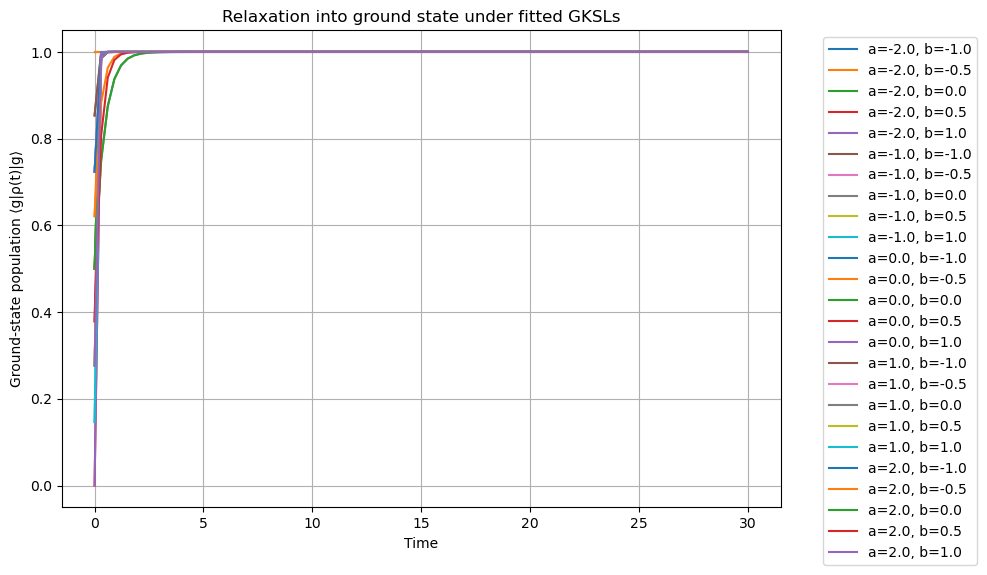

In [10]:
plt.figure(figsize=(10,6))
for key, res in results_all.items():
    a, b = key
    plt.plot(tlist, res["p_ground"], label=f"a={a:.1f}, b={b:.1f}")
plt.xlabel("Time")
plt.ylabel("Ground-state population ⟨g|ρ(t)|g⟩")
plt.title("Relaxation into ground state under fitted GKSLs")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.grid(True)
plt.show()